In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx") #./../../data/Preise.xlsx   - Pfad für Sandbox
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

In [3]:
df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "A",
                         "Region B": "B",
                         "Region C": "C",
                         "Region D": "D"})
)

In [4]:
df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

In [5]:
def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))

df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

In [6]:
# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifische Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

## Hypothese: Die Downtime des Zahlungsdienstleisters hat Einfluss auf die Verkaufszahlen im Onlinehandel

Zunächst sollte eine Übersicht über die Downtime und die Verkaufszahlen erstellt werden, um so potentielle Zusammenhänge erkennen zukönnen. </br>
Für diese Übersicht sollten alle Transaktionen aus dem Onlinehandel separat betrachtet werden.

In [7]:
df_dt

,year,A,B,C,D
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


<Axes: xlabel='year'>

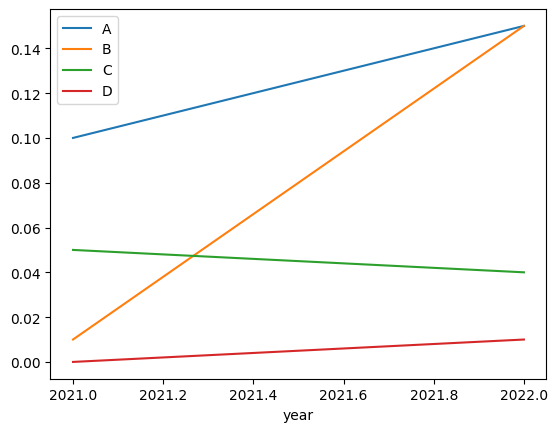

In [8]:
df_dt.plot(x="year")

In der Übersicht der Downtime kann man erkennen, dass die Downtime in den Regionen A und B erheblich steigt, während diese in C und D stagniert oder sogar leicht sinkt. Nun sollte überpürft werden, ob es einen Zusammenhang zwischen der Downtime und den Verkaufszahlen im Onlinehandel gibt. Hierzu kann geprüft werden, ob sich die Verkaufszahlen entsprechend der Downtimes in den Regionen verändern. Dazu müssen zunächst alle Transaktionen aus dem Onlinehandel zusammengefasst werden. </br>

In [9]:
dataframes_online = [
    df_regAo,
    df_regBo,
    df_regCo,
    df_regDo
]


df_online = pd.concat(dataframes_online, ignore_index=True)
df_online.head()

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,44,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,44,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,44,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,44,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,44,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online


Nach dem Erstellen des Dataframes mit allen Online Transaktionen kann nun geprüft werden, ob für die weitere Analyse noch weitere Handlungen (NaN-Werte, Quantile o.ä.) nötig sind.

In [10]:
df_online.describe()

,date,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,transaction_id,year,month,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating
count,84999,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000,47867.000000,22121.000000,15011.000000,84999.000000,84999.000000,84999.000000,84999.0,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000
mean,2022-04-12 13:10:23.993223424,0.980430,2.822527,0.563148,0.260250,0.176602,261.276245,173.622811,797.917411,142358.742115,2021.789103,6.416252,26.109801,333.236373,920.658670,610.859328,1690.300133,277.622955,769.641463,6.701702
min,2021-11-01 00:00:00,0.900000,1.000000,0.000000,0.000000,0.000000,150.000000,136.020000,530.790000,1.000000,2021.000000,1.000000,1.0,136.020000,136.020000,499.000000,499.000000,-79.600000,-796.000000,1.600000
25%,2022-01-12 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,200.390000,156.470000,753.910000,58357.500000,2022.000000,3.000000,12.0,182.810000,336.455000,499.000000,998.000000,197.265000,354.160000,5.300000
50%,2022-04-03 00:00:00,1.000000,2.000000,1.000000,0.000000,0.000000,248.700000,174.410000,804.560000,129493.000000,2022.000000,6.000000,25.0,233.770000,630.870000,529.000000,1497.000000,276.810000,590.560000,6.700000
75%,2022-07-07 00:00:00,1.000000,3.000000,1.000000,1.000000,0.000000,311.840000,191.250000,847.710000,218900.500000,2022.000000,10.000000,41.0,355.300000,1166.605000,550.000000,2040.000000,364.860000,1025.445000,8.000000
max,2022-10-31 00:00:00,1.000000,17.000000,1.000000,1.000000,1.000000,578.600000,216.620000,894.980000,339990.000000,2022.000000,12.000000,52.0,894.980000,9557.520000,999.000000,12987.000000,484.000000,7110.600000,10.000000
std,NaN,0.039674,1.998163,0.495999,0.438774,0.381334,74.685524,20.176643,61.529747,95865.662855,0.407948,3.646071,15.873983,227.147611,914.666875,183.681424,1264.109259,101.763708,641.191241,1.761070


Dass keine NaN-Werte vorhanden sind wurde bereits bei der ersten Datenaufbereitung festgestellt. Im describe des Dataframes lässt sich auch feststellen, dass bei den numerischen Werten keine zu entfernenden Ausreißer gibt. Daher können die vorhandenen Daten für die weitere Analyse gnutzt werden. </br>
Nun kann also die allgemeine Entwicklung des Onlinehandels mit der Entwicklung in den einzelnen Regionen verglichen werden, um so zu prüfen ob die Regionen mit einer höheren oder steigenden Downtime schlechter performen als die Regionen mit einer niedrigeren bzw. sinkenden Downtime.

[Text(0.5, 1.0, 'Transaktionen pro Monat im Onlinehandel')]

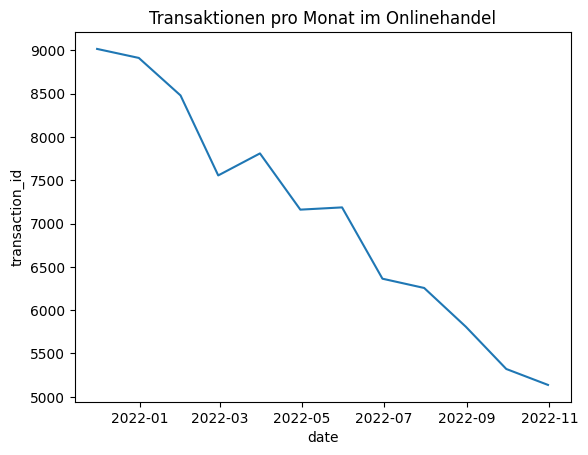

In [11]:
trans_per_month_online = df_online.groupby(pd.Grouper(key="date", freq="1M")).agg({"transaction_id": "count"})

ax = sns.lineplot(data=trans_per_month_online, x="date", y="transaction_id")
ax.set(title="Transaktionen pro Monat im Onlinehandel")

[Text(0.5, 1.0, '⌀ Umsatz pro Monat im Onlinehandel')]

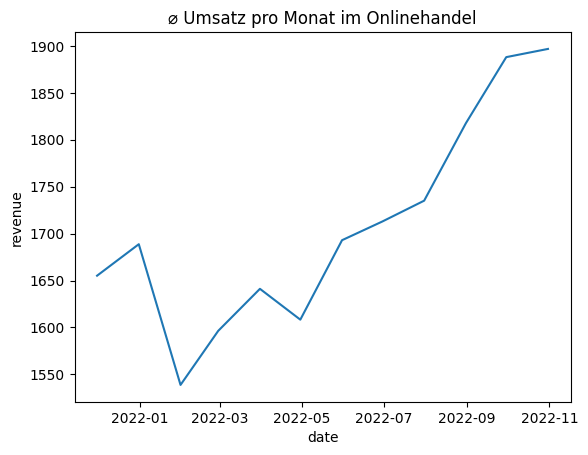

In [12]:
rev_per_week_online = df_online.groupby(pd.Grouper(key="date", freq="1M")).agg({"revenue": "mean"})

ax = sns.lineplot(data=rev_per_week_online, x="date", y="revenue")
ax.set(title="⌀ Umsatz pro Monat im Onlinehandel")

[Text(0.5, 1.0, '⌀ Profit pro Monat im Onlinehandel')]

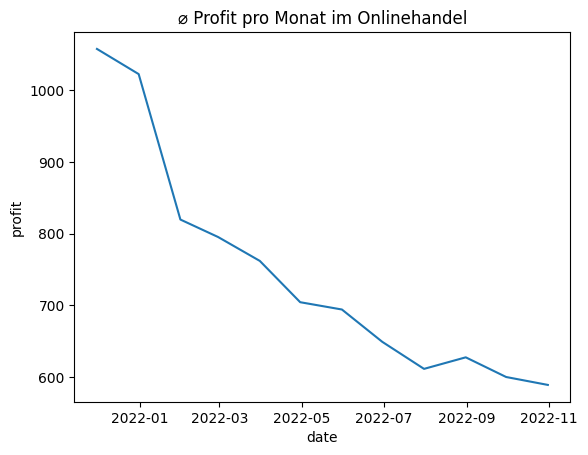

In [13]:
profit_per_week_online = df_online.groupby(pd.Grouper(key="date", freq="1M")).agg({"profit": "mean"}) # Gewinn pro Monat -> Klarer Gewinnrückgang

ax = sns.lineplot(data=profit_per_week_online, x="date", y="profit")
ax.set(title="⌀ Profit pro Monat im Onlinehandel")

Im Onlinehandel zeichnet sich ein negativer Trend ab, welcher zu der Entwicklung des restlichen Unternehmens passt. Der Umsatz steigt, während die Transaktionszahl und der Profit sinken. </br>
Die weiterhin bestehende Frage ist nun der Zusammenhang dieses Trends mit der Downtime. Hierzu muss nun zunächst die Entwicklung in den einzelnen Regionen betrachtet werden.

[Text(0.5, 1.0, 'Transaktionen pro Monat im Onlinehandel (regional)')]

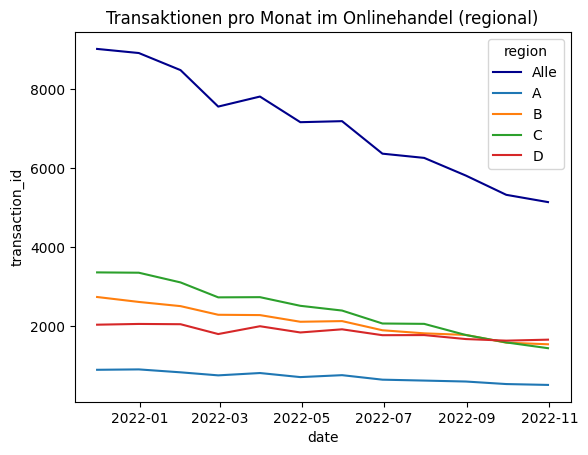

In [14]:
trans_per_month_online_regs = df_online.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"transaction_id": "count"})

ax = sns.lineplot(data=trans_per_month_online, x="date", y="transaction_id", color="darkblue", label="Alle")
ax = sns.lineplot(data=trans_per_month_online_regs, x="date", y="transaction_id", hue="region")
ax.set(title="Transaktionen pro Monat im Onlinehandel (regional)")

[Text(0.5, 1.0, '⌀ Umsatz pro Monat im Onlinehandel (regional)')]

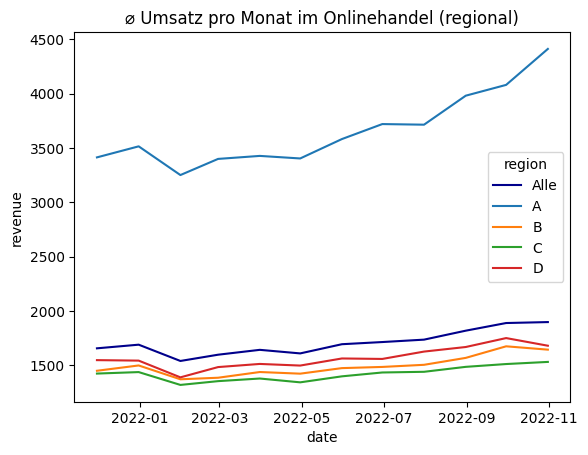

In [15]:
rev_per_week_online_regs = df_online.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"revenue": "mean"})

ax = sns.lineplot(data=rev_per_week_online, x="date", y="revenue", color="darkblue", label="Alle")
ax = sns.lineplot(data=rev_per_week_online_regs, x="date", y="revenue", hue="region")
ax.set(title="⌀ Umsatz pro Monat im Onlinehandel (regional)")

[Text(0.5, 1.0, '⌀ Profit pro Monat im Onlinehandel (regional)')]

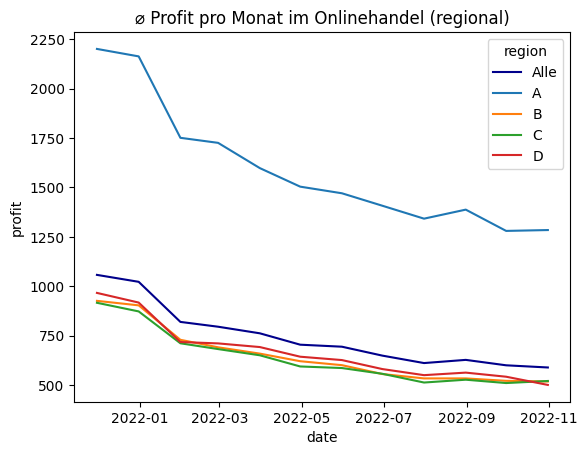

In [16]:
profit_per_week_online_regs = df_online.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"profit": "mean"})

ax = sns.lineplot(data=profit_per_week_online, x="date", y="profit", color="darkblue", label="Alle")
ax = sns.lineplot(data=profit_per_week_online_regs, x="date", y="profit", hue="region")
ax.set(title="⌀ Profit pro Monat im Onlinehandel (regional)")

Man kann hier sehen, dass alle Regionen einen ähnlichen Trend zeigen wie auch die Gesamtübersicht über den Onlinehandel. Die Region A ist zwar ein Ausreißer im Gegensatz zu den anderen 3 Regionen in Bezug auf die verzeichneten Werte, der Verlauf über die Zeit zeichnet sich aber bei allen Regionen ähnlich ab. Da die Regionen aber unterschiedliche Downtime Werte und auch unterschiedliche Verläufe der Downtime haben, lässt hier der erste Überblick darauf schließen, dass die Downtime keinen wesentlichen Einfluss auf die Verkäufe im Onlinehandel hat. </br>
Region A hat zwar die höchste Downtime und die geringsten Transaktionszahlen, was für einen Zusammenhang sprechen würde. Allerdings hat Region B einen starken Anstieg in der Downtime, von 1% auf 15%, allerdings zeichnet sich hier dieser Anstieg nicht in den Transaktionszahlen ab. In Region B bleibt der Verlauf der Transaktionszahlen ähnlich des Verlaufes in den anderen Regionen und der Gesamtübersicht. In Region B ist sogar ein geringerer Verlust der Transaktionszahlen zu erkennen als in region C, obwohl in Region die Downtime um 14% gestiegen ist, während sie in Region C um 1% gesunken ist. </br>
Der erste Überblick legt also nahe, dass es keinen Zusammenhang zwischen der Downtime und der Performance des Online Handels gibt. Um einen möglichen Zusammenhang weiter zu widerlegen kann man nun noch versuchen ein Modell aufzubauen, welches versucht einen Zusammenhang zwischen der Downtime und der Performance herzustellen.

In [17]:
df_online_dt = pd.merge(df_online, df_dt, on='year', how='left')
for col in ['A', 'B', 'C', 'D']:
    df_online_dt.loc[df_online_dt['region'] == col, 'downtime'] = df_online_dt[col]

df_online_dt = df_online_dt.drop(["A", "B", "C", "D"], axis=1)

df_online_dt.head()

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace,downtime
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online,0.1
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online,0.1
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online,0.1
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online,0.1
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online,0.1


In [74]:
df_online_dt_week = df_online_dt.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"transaction_id": "count", "amount": "mean", "profit": "mean", "revenue": "mean", "customer_rating": "mean", "downtime": "median"}).reset_index()
df_online_dt_week.head()

,region,date,transaction_id,amount,profit,revenue,customer_rating,downtime
0,A,2021-11-07,217,5.843318,2185.394977,3352.889401,7.294009,0.1
1,A,2021-11-14,198,6.257576,2302.977778,3561.363636,7.242424,0.1
2,A,2021-11-21,210,5.980952,2179.715048,3388.538095,7.276190,0.1
3,A,2021-11-28,207,5.951691,2173.355700,3401.937198,7.023671,0.1
4,A,2021-12-05,211,5.872038,2115.551611,3363.985782,6.915640,0.1


In [73]:
model_online = smf.ols("transaction_id ~ downtime + customer_rating", data=df_online_dt_week).fit()
model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     33.40
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           6.02e-28
Time:                        17:10:50   Log-Likelihood:                -1329.3
No. Observations:                 212   AIC:                             2673.
Df Residuals:                     205   BIC:                             2696.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1435.2064    219.630      6.535      0.000    1002.183    1868.230
downtime[T.0.01]   -57.2361     47.388     -1.208      0.229    -150.667      36.195
downtime[T.0.04]   -92.4655     55.381     -1.670      0.097    -201.655      16.724
downtime[T.0.05]   258.1939     62.018      4.163      0.000     135.919     380.469
downtime[T.0.1]   -293.9153     61.712     -4.763      0.000    -415.588    -172.243
downtime[T.0.15]  -249.1093     48.913     -5.093      0.000    -345.546    -152.673
customer_rating   -133.0558     29.647     -4.488      0.000    -191.507     -74.605
==============================================================================
Omnibus:                        8.678   Durbin-Watson:                   0.296
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                6.680
Skew:                           0.328   Prob(JB):                       0.0354
Kurtosis:                       2.430   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Das erstellte Modell zeigt, dass die Downtime in Kombination mit dem Customer Rating keinen erheblichen Einfluss auf die Transaktionszahlen hat. 

In [75]:
model_online = smf.ols("amount ~ downtime + customer_rating", data=df_online_dt_week).fit()
model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     27.20
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           9.25e-24
Time:                        17:12:30   Log-Likelihood:                -325.23
No. Observations:                 212   AIC:                             664.5
Df Residuals:                     205   BIC:                             688.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.8224      1.927      1.465      0.144      -0.976       6.621
downtime[T.0.01]    -0.1034      0.416     -0.249      0.804      -0.923       0.716
downtime[T.0.04]    -0.0830      0.486     -0.171      0.865      -1.041       0.875
downtime[T.0.05]    -0.0118      0.544     -0.022      0.983      -1.084       1.061
downtime[T.0.1]      3.4691      0.541      6.408      0.000       2.402       4.536
downtime[T.0.15]     1.6195      0.429      3.774      0.000       0.773       2.465
customer_rating     -0.0407      0.260     -0.157      0.876      -0.553       0.472
==============================================================================
Omnibus:                        3.029   Durbin-Watson:                   0.064
Prob(Omnibus):                  0.220   Jarque-Bera (JB):                2.194
Skew:                           0.064   Prob(JB):                        0.334
Kurtosis:                       2.519   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Bei der durchschnittlichen verkauften Menge sieht der Einfluss auch nicht stärker aus. </br>
## Fazit
Hieraus lässt sich also schließen, dass die Downtine keinen wesentlichen Einfluss auf die Verkaufszahlen hat und daher auch nicht maßgeblich für die verschlechternde wirtschaftliche Situation des Unternehmens zuständig ist. Daher ist die Hypothese widerlegt.

# ALT

<Axes: xlabel='date', ylabel='profit'>

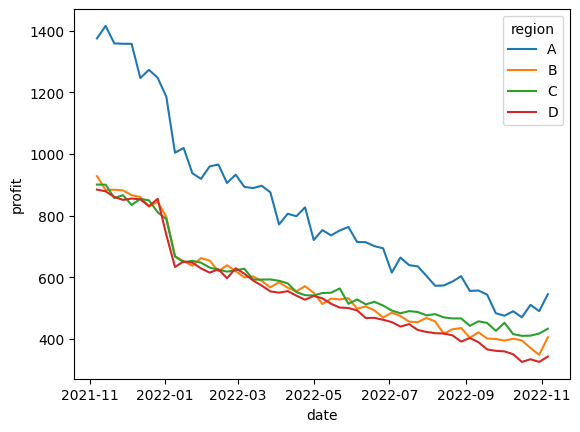

In [24]:
profit_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"profit": "mean"})
sns.lineplot(data=profit_per_week_vis, x="date", y="profit", hue="region")

<Axes: xlabel='date', ylabel='revenue'>

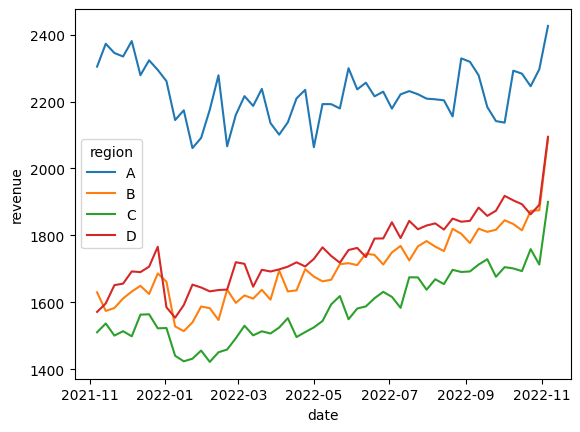

In [25]:
rev_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"revenue": "mean"})
sns.lineplot(data=rev_per_week_vis, x="date", y="revenue", hue="region")

transaction_id
region date                      
A      2021-11-07             547
       2021-11-14             520
       2021-11-21             556
       2021-11-28             528
       2021-12-05             525
...                           ...
D      2022-10-09            2682
       2022-10-16            2648
       2022-10-23            2756
       2022-10-30            2734
       2022-11-06             388

[212 rows x 1 columns]

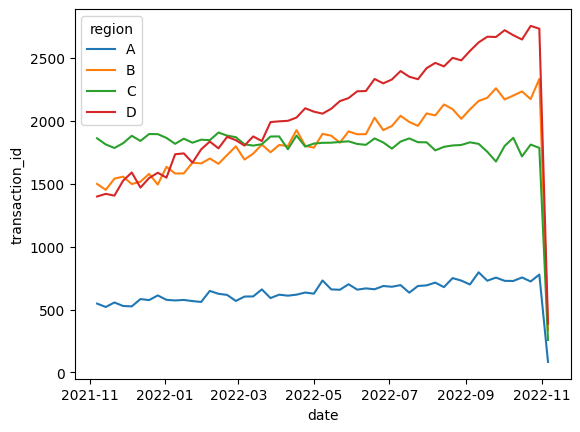

In [26]:
trans_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"transaction_id": "count"})
sns.lineplot(data=trans_per_week_vis, x="date", y="transaction_id", hue="region")
trans_per_week_vis

<Axes: xlabel='date', ylabel='transaction_id'>

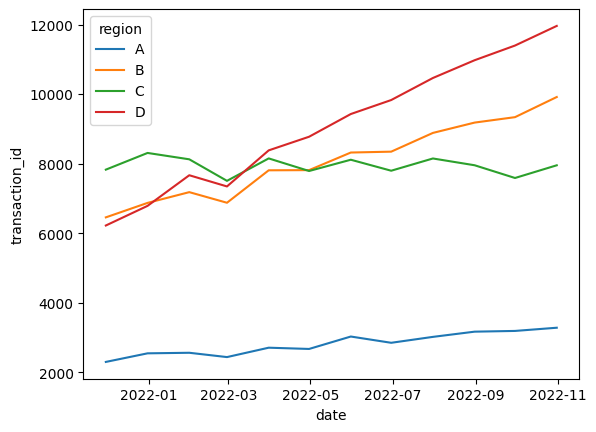

In [27]:
trans_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"transaction_id": "count"})
sns.lineplot(data=trans_per_week_vis, x="date", y="transaction_id", hue="region")

In [28]:
df_dt

,year,A,B,C,D
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


<Axes: xlabel='date', ylabel='revenue'>

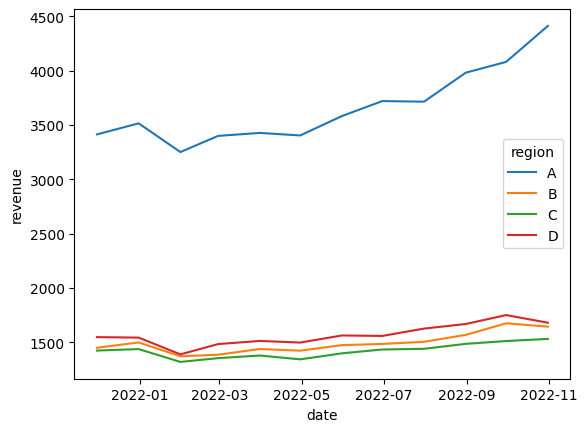

In [29]:
rev_per_week_online = df_online.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"revenue": "mean"})
sns.lineplot(data=rev_per_week_online, x="date", y="revenue", hue="region")

<Axes: xlabel='date', ylabel='profit'>

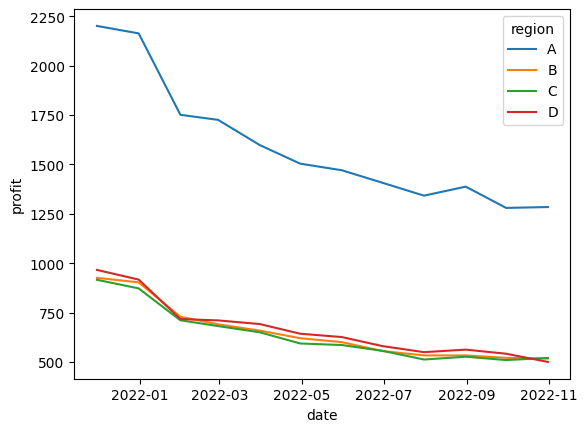

In [30]:
profit_per_week_online = df_online.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"profit": "mean"})
sns.lineplot(data=profit_per_week_online, x="date", y="profit", hue="region")

<Axes: xlabel='date', ylabel='transaction_id'>

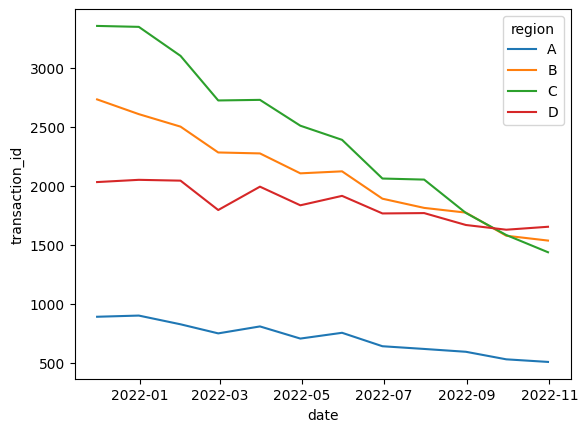

In [31]:
trans_per_week_online = df_online.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"transaction_id": "count"})
sns.lineplot(data=trans_per_week_online, x="date", y="transaction_id", hue="region")

In [32]:
df_dt

,year,A,B,C,D
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


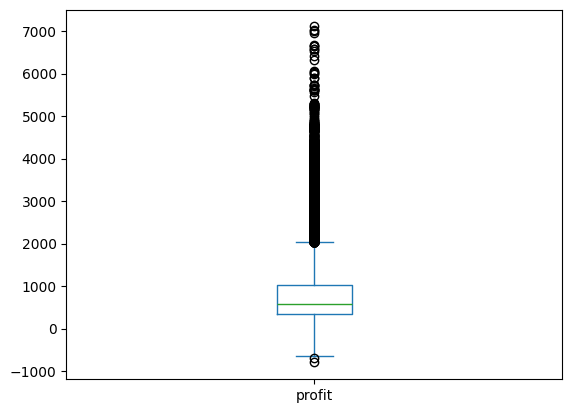

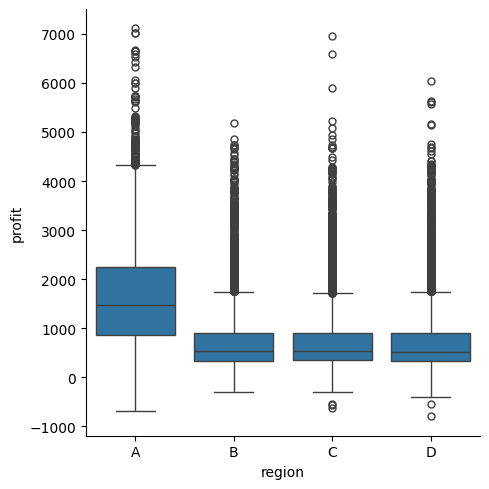

In [33]:
df_online.plot(x="region", y="profit", kind="box")

sns.catplot(data=df_online, x="region", y="profit", kind="box")

In [34]:
df_online.describe()

,date,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,transaction_id,year,month,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating
count,84999,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000,47867.000000,22121.000000,15011.000000,84999.000000,84999.000000,84999.000000,84999.0,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000,84999.000000
mean,2022-04-12 13:10:23.993223424,0.980430,2.822527,0.563148,0.260250,0.176602,261.276245,173.622811,797.917411,142358.742115,2021.789103,6.416252,26.109801,333.236373,920.658670,610.859328,1690.300133,277.622955,769.641463,6.701702
min,2021-11-01 00:00:00,0.900000,1.000000,0.000000,0.000000,0.000000,150.000000,136.020000,530.790000,1.000000,2021.000000,1.000000,1.0,136.020000,136.020000,499.000000,499.000000,-79.600000,-796.000000,1.600000
25%,2022-01-12 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,200.390000,156.470000,753.910000,58357.500000,2022.000000,3.000000,12.0,182.810000,336.455000,499.000000,998.000000,197.265000,354.160000,5.300000
50%,2022-04-03 00:00:00,1.000000,2.000000,1.000000,0.000000,0.000000,248.700000,174.410000,804.560000,129493.000000,2022.000000,6.000000,25.0,233.770000,630.870000,529.000000,1497.000000,276.810000,590.560000,6.700000
75%,2022-07-07 00:00:00,1.000000,3.000000,1.000000,1.000000,0.000000,311.840000,191.250000,847.710000,218900.500000,2022.000000,10.000000,41.0,355.300000,1166.605000,550.000000,2040.000000,364.860000,1025.445000,8.000000
max,2022-10-31 00:00:00,1.000000,17.000000,1.000000,1.000000,1.000000,578.600000,216.620000,894.980000,339990.000000,2022.000000,12.000000,52.0,894.980000,9557.520000,999.000000,12987.000000,484.000000,7110.600000,10.000000
std,NaN,0.039674,1.998163,0.495999,0.438774,0.381334,74.685524,20.176643,61.529747,95865.662855,0.407948,3.646071,15.873983,227.147611,914.666875,183.681424,1264.109259,101.763708,641.191241,1.761070


In [35]:
df_online["downtime"] = ""

In [36]:
df_dt

,year,A,B,C,D
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


In [37]:
df_dt.loc[:, df_online["region"]]

,A,A,A,A,A,A,A,A,A,A,...,D,D,D,D,D,D,D,D,D,D
0,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [38]:
df_online

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace,downtime
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online,
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online,
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online,
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online,
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84994,2022-10-31,Tablet Mini,1.0,3,0,1,0,NaN,136.06,NaN,...,136.06,408.18,550,1650,413.94,1241.82,6.1,D,online,
84995,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.06,NaN,...,136.06,136.06,550,550,413.94,413.94,8.0,D,online,
84996,2022-10-31,Tablet Mini,1.0,2,0,1,0,NaN,136.06,NaN,...,136.06,272.12,550,1100,413.94,827.88,7.5,D,online,
84997,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.02,NaN,...,136.02,136.02,550,550,413.98,413.98,6.8,D,online,


In [39]:
df_online_dt = pd.merge(df_online, df_dt, on='year', how='left')
for col in ['A', 'B', 'C', 'D']:
    df_online_dt.loc[df_online_dt['region'] == col, 'downtime'] = df_online_dt[col]

df_online_dt = df_online_dt.drop(["A", "B", "C", "D"], axis=1)

df_online_dt

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace,downtime
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online,0.1
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online,0.1
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online,0.1
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online,0.1
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84994,2022-10-31,Tablet Mini,1.0,3,0,1,0,NaN,136.06,NaN,...,136.06,408.18,550,1650,413.94,1241.82,6.1,D,online,0.01
84995,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.06,NaN,...,136.06,136.06,550,550,413.94,413.94,8.0,D,online,0.01
84996,2022-10-31,Tablet Mini,1.0,2,0,1,0,NaN,136.06,NaN,...,136.06,272.12,550,1100,413.94,827.88,7.5,D,online,0.01
84997,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.02,NaN,...,136.02,136.02,550,550,413.98,413.98,6.8,D,online,0.01


In [62]:
df_online_dt_week = df_online_dt.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"transaction_id": "count", "profit": "mean", "revenue": "mean", "customer_rating": "mean", "downtime": "median"})
df_online_dt_week

transaction_id       profit      revenue  customer_rating  \
region date                                                                    
A      2021-11-07             217  2185.394977  3352.889401         7.294009   
       2021-11-14             198  2302.977778  3561.363636         7.242424   
       2021-11-21             210  2179.715048  3388.538095         7.276190   
       2021-11-28             207  2173.355700  3401.937198         7.023671   
       2021-12-05             211  2115.551611  3363.985782         6.915640   
...                           ...          ...          ...              ...   
D      2022-10-09             386   520.686166  1699.261658         7.488083   
       2022-10-16             337   527.181276  1673.540059         7.474184   
       2022-10-23             388   501.955644  1750.840206         7.570619   
       2022-10-30             369   486.406965  1693.075881         7.758808   
       2022-11-06              53   491.038491  1903.962264         7.739623   

                  downtime  
region date                 
A      2021-11-07      0.1  
       2021-11-14      0.1  
       2021-11-21      0.1  
       2021-11-28      0.1  
       2021-12-05      0.1  
...                    ...  
D      2022-10-09     0.01  
       2022-10-16     0.01  
       2022-10-23     0.01  
       2022-10-30     0.01  
       2022-11-06     0.01  

[212 rows x 5 columns]

<Axes: xlabel='date', ylabel='customer_rating'>

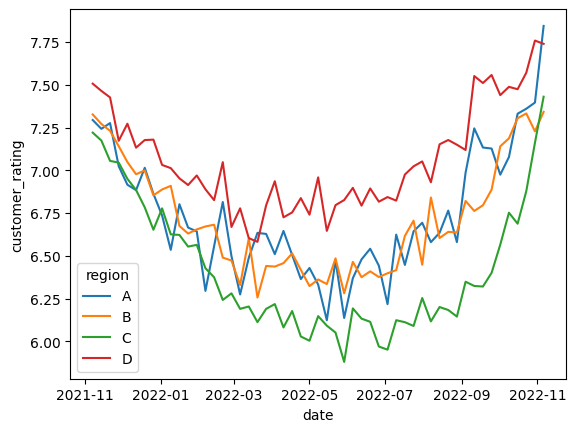

In [63]:
sns.lineplot(data=df_online_dt_week, x="date", y="customer_rating", hue="region")

In [64]:
model_online = smf.ols("profit ~ downtime + customer_rating", data=df_online_dt_week.loc[("A")]).fit()
model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     81.23
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           1.96e-16
Time:                        16:54:10   Log-Likelihood:                -340.22
No. Observations:                  53   AIC:                             686.4
Df Residuals:                      50   BIC:                             692.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3398.4693    437.464      7.769      0.000    2519.797    4277.142
downtime[T.0.15]  -756.1937     59.946    -12.615      0.000    -876.598    -635.789
customer_rating   -175.8711     61.825     -2.845      0.006    -300.051     -51.691
==============================================================================
Omnibus:                        3.590   Durbin-Watson:                   0.704
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                3.125
Skew:                           0.595   Prob(JB):                        0.210
Kurtosis:                       2.974   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
model_online = smf.ols("transaction_id ~ downtime", data=df_online_dt_week.loc[("B")]).fit()
model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     23.66
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           1.15e-05
Time:                        16:54:12   Log-Likelihood:                -313.41
No. Observations:                  53   AIC:                             630.8
Df Residuals:                      51   BIC:                             634.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          610.8889     30.420     20.082      0.000     549.819     671.959
downtime[T.0.15]  -162.3889     33.386     -4.864      0.000    -229.414     -95.363
==============================================================================
Omnibus:                       27.356   Durbin-Watson:                   0.369
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.026
Skew:                          -1.392   Prob(JB):                     3.77e-16
Kurtosis:                       7.940   Cond. No.                         4.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
model_online = smf.ols("transaction_id ~ downtime", data=df_online_dt_week.loc[("C")]).fit()
model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     30.28
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           1.22e-06
Time:                        16:47:50   Log-Likelihood:                -332.87
No. Observations:                  53   AIC:                             669.7
Df Residuals:                      51   BIC:                             673.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          503.5682     19.860     25.356      0.000     463.697     543.439
downtime[T.0.05]   265.2096     48.195      5.503      0.000     168.455     361.964
==============================================================================
Omnibus:                        7.420   Durbin-Watson:                   0.230
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.030
Skew:                          -0.628   Prob(JB):                       0.0297
Kurtosis:                       4.267   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
model_online = smf.ols("transaction_id ~ downtime", data=df_online_dt_week.loc[("D")]).fit()
model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     7.138
Date:                Tue, 16 Jan 2024   Prob (F-statistic):             0.0101
Time:                        16:47:50   Log-Likelihood:                -293.39
No. Observations:                  53   AIC:                             590.8
Df Residuals:                      51   BIC:                             594.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          468.8889     20.850     22.488      0.000     427.030     510.748
downtime[T.0.01]   -61.1389     22.884     -2.672      0.010    -107.080     -15.198
==============================================================================
Omnibus:                       71.775   Durbin-Watson:                   0.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.320
Skew:                          -3.518   Prob(JB):                    2.52e-187
Kurtosis:                      21.429   Cond. No.                         4.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Backlog Code

In [46]:
dataframes_a = [
    df_regAo,
    df_regAp,
    df_regAs
]

dataframes_b = [
    df_regBo,
    df_regBp,
    df_regBs
]

dataframes_c = [
    df_regCo,
    df_regCp,
    df_regCs
]

dataframes_d = [
    df_regDo,
    df_regDp,
    df_regDs
]

df_a = pd.concat(dataframes_a, ignore_index=True)
df_b = pd.concat(dataframes_b, ignore_index=True)
df_c = pd.concat(dataframes_c, ignore_index=True)
df_d = pd.concat(dataframes_d, ignore_index=True)